# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [2]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 45.88 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [6]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target **~60%**, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### SET UP THE GPU

In [7]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is enabled and available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

GPU is enabled and available.
Device name: Tesla T4


In [8]:
import random
import time
from typing import Tuple, List, Optional
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import copy

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torchvision import transforms
from torch.optim import AdamW
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, ConcatDataset, Subset
from torchvision import transforms as T, datasets
from torch.optim.lr_scheduler import OneCycleLR

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [9]:
# For repeatability
def fix_random(seed: int) -> None:

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

### EXPLORE THE DATASET

Training Set Class Distribution:
Counter({0: 278, 19: 247, 20: 182, 27: 181, 7: 154, 41: 127, 13: 116, 38: 112, 39: 75, 18: 70, 26: 60, 9: 57, 25: 51, 23: 48, 3: 46, 2: 45, 31: 43, 4: 42, 1: 41, 36: 39, 37: 38, 12: 37, 8: 36, 17: 34, 21: 33, 6: 32, 22: 32, 5: 31, 24: 30, 42: 30, 11: 28, 32: 28, 14: 26, 16: 26, 33: 25, 35: 23, 15: 22, 29: 22, 10: 21, 30: 19, 34: 19, 40: 18, 28: 16})
 
Validation Set Class Distribution:
Counter({19: 29, 20: 26, 0: 22, 7: 20, 27: 20, 38: 15, 25: 10, 39: 10, 41: 8, 2: 6, 1: 5, 3: 5, 4: 5, 5: 5, 9: 5, 11: 5, 12: 5, 13: 5, 14: 5, 16: 5, 17: 5, 18: 5, 22: 5, 21: 5, 23: 5, 28: 5, 36: 5, 30: 5, 31: 5, 32: 5, 37: 5, 40: 5, 42: 5, 29: 4, 34: 4, 35: 4, 6: 3})
 


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


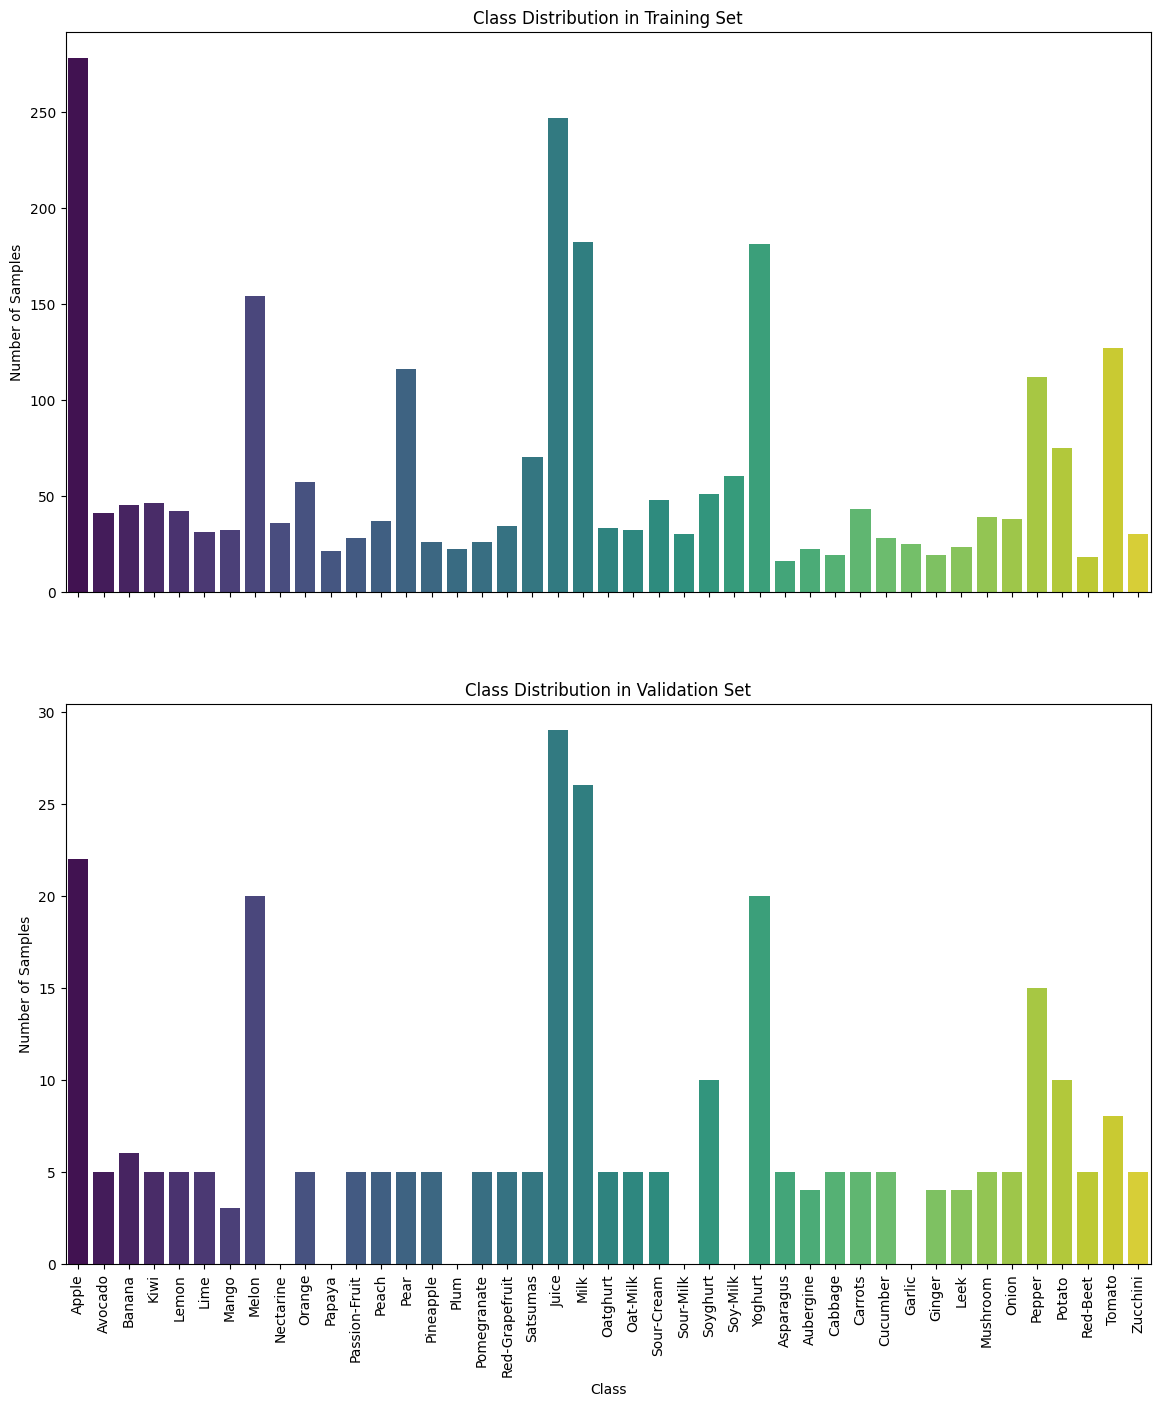

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

INPUT_WIDTH = 256
INPUT_HEIGHT = 256

train_dataset = GroceryStoreDataset(split="train", transform=None)
test_dataset = GroceryStoreDataset(split="test", transform=None)
val_dataset = GroceryStoreDataset(split="val", transform=None)

# Count the occurrences of each class label in the training set
train_label_counts = Counter(train_dataset.labels)
print("Training Set Class Distribution:")
print(train_label_counts)
print(" ")

# Count the occurrences of each class label in the validation set
val_label_counts = Counter(val_dataset.labels)
print("Validation Set Class Distribution:")
print(val_label_counts)
print(" ")

# Define the class names
class_names = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon",
    "Nectarine", "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear",
    "Pineapple", "Plum", "Pomegranate", "Red-Grapefruit", "Satsumas",
    "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", "Sour-Milk",
    "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage",
    "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom",
    "Onion", "Pepper", "Potato", "Red-Beet", "Tomato", "Zucchini"
]

# Convert label counts to lists sorted by class index
train_label_count_list = [train_label_counts[i] for i in range(len(class_names))]
val_label_count_list = [val_label_counts[i] for i in range(len(class_names))]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

# Plot training set distribution
sns.barplot(ax=axes[0], x=class_names, y=train_label_count_list, palette="viridis")
axes[0].set_title("Class Distribution in Training Set")
axes[0].set_ylabel("Number of Samples")

# Plot validation set distribution
sns.barplot(ax=axes[1], x=class_names, y=val_label_count_list, palette="viridis")
axes[1].set_title("Class Distribution in Validation Set")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Number of Samples")

plt.xticks(rotation=90)
plt.show()

# compute class weights, maybe can improve generalization performance (actually no)
class_sample_count = train_label_counts
num_classes = len(class_sample_count)
class_weights = torch.tensor([1.0/class_sample_count[t] for t in range(num_classes)], dtype=torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

In [11]:
print(f'The number of classes is = {train_dataset.get_num_classes()}')
NUM_CLASSES = train_dataset.get_num_classes()

The number of classes is = 43


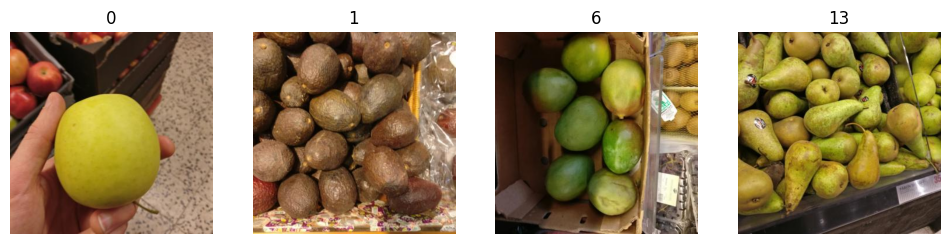

In [11]:
#@title Let's visualize some images from different classes
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

# Define the transform to convert PIL to tensor
to_tensor = transforms.ToTensor()

for i, idx in enumerate([0, 300, 500, 900]):
    img, label = train_dataset[idx]

    # Convert PIL image to tensor
    img_tensor = to_tensor(img)

    # Rearrange the tensor to (height, width, channels) for imshow
    ax[i].imshow(img_tensor.permute(1, 2, 0))
    ax[i].set_title(label)
    ax[i].axis("off")

plt.show()

In [12]:
print(f'Train dataset has {len(train_dataset)} elements')
print(f'Validation dataset has {len(val_dataset)} elements')
print(f'Test dataset has {len(test_dataset)} elements')

Train dataset has 2640 elements
Validation dataset has 296 elements
Test dataset has 2485 elements


### DATA PREPROCESSING
Let's explore some data preprocessing, using different techniques.

#### Augmentation

In [ ]:
augmentation_transforms = [T.Compose([
    T.Resize((INPUT_HEIGHT, INPUT_WIDTH)),
    T.RandomHorizontalFlip(p=0.5),  # Horizontal flip is reasonable
    T.RandomRotation(5),  # Lower the rotation angle
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Mild color jitter
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])]

augmented_train_dset = GroceryStoreDataset(split="train", transform=augmentation_transforms)
train_dataset = ConcatDataset([train_dataset, augmented_train_dset])
print(f'Train dataset size after augmentation: {len(train_dataset)}')
torch.save(train_dataset, 'train_dset.pt')


Train dataset size after augmentation: 5280


#### Rebalancing

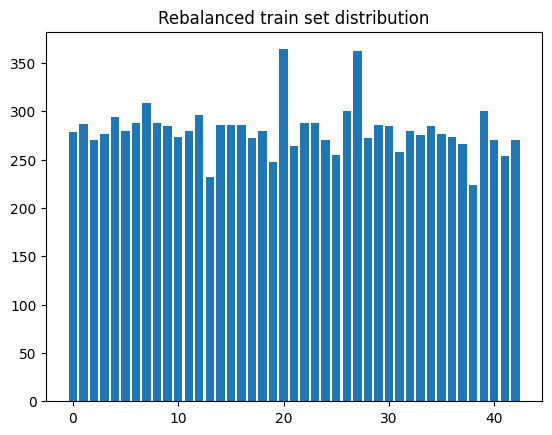

In [ ]:
import random
import numpy as np
from torch.utils.data import ConcatDataset

transform = [transforms.Compose([
        transforms.Resize((INPUT_HEIGHT, INPUT_WIDTH)),      # Resize images to 224x224 pixels (common practice)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),      # Randomly rotate images by up to 10 degrees
        transforms.ToTensor(),              # Convert images to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize dataset
    ])]

class GroceryStoreDatasetFilteredByLabel(GroceryStoreDataset):
    def __init__(self, split: str, transform=None, label=None) -> None:
        super().__init__(split, transform)
        self.paths = [p for i, p in enumerate(self.paths) if self.labels[i] == label]
        self.labels = [label] * len(self.paths)

def balanceDataset(split, seed=42):
    fix_random(seed)

    # Initial dataset
    base_dset = GroceryStoreDataset(split=split, transform=tsfms)
    balanced_dset = base_dset
    balanced_count = [base_dset.labels.count(i) for i in range(NUM_CLASSES)]
    biggest_class_size = np.max(balanced_count)

    # Copy labels separately as ConcatDataset does not store labels
    all_labels = list(base_dset.labels)

    for i in range(NUM_CLASSES):
        size_label_i = all_labels.count(i)
        increase_factor = round(biggest_class_size / size_label_i)

        for j in range(increase_factor - 1):
            # Safely access augmentation_transforms by checking its length
            transform_idx = j % len(transform)
            augmented_dset = GroceryStoreDatasetFilteredByLabel(split=split, transform=transform[transform_idx], label=i)
            balanced_dset = ConcatDataset([balanced_dset, augmented_dset])

            # Update the label count
            balanced_count[i] += len(augmented_dset)
            all_labels += augmented_dset.labels

    return balanced_dset, balanced_count


# Call the balanceDataset function
train_dataset, balanced_count = balanceDataset("train")

# Plotting the rebalanced dataset
plt.title("Rebalanced train set distribution")
plt.bar(range(NUM_CLASSES), balanced_count)
plt.show()

In [ ]:
print(f'Train dataset size after rebalancing: {len(train_dataset)}')

Train dataset size after rebalancing: 12056


In [ ]:
# Get the total number of samples
dataset_size = len(train_dataset)

# Define the size of the subset
subset_size = int(0.22 * dataset_size)

# Create a subset with the first 80% of the data
train_dataset = Subset(train_dataset, range(subset_size))

In [ ]:
print(f'Train sub-dataset size: {len(train_dataset)}')

Train sub-dataset size: 2652


#### Class weighting

In [ ]:
labels = np.array(train_dataset.labels)
print(labels)

[ 0  0  0 ... 42 42 42]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)
class_weights_tensor = class_weights_tensor.to(device)

#### Comments
We tested all of these configurations, but unfortunately, none of them produced satisfactory results. They resulted in low accuracy and significantly high validation losses. Moving forward, we will focus on exploring the undersampling technique, as it showed promising results.

### Defining the Models
Here’s a summary of the different ResNet architectures we are evaluating, each with varying levels of complexity:

**ResidualCNN_v1**: This version serves as the most basic ResNet-like architecture. It has simple convolutional blocks with residual skip connections, making it easier for gradients to flow through deeper layers during backpropagation. The absence of dropout makes it essential for evaluating the direct impact of dropout on the model's performance by comparing it with other models that use dropout, serving as key component for ablation studies. Its structure is based on standard residual blocks, where each block has two convolutional layers followed by batch normalization. This architecture doesn't regularize via dropout, which may make it more prone to overfitting, especially on small datasets. The higher number of parameters due to the lack of parameter reduction techniques could also limit its ability to scale.

**ResidualCNN_v2**: This version improves on *ResidualCNN_v1* by incorporating dropout and reducing the number of parameters. Dropout is introduced after the final fully connected layer to regularize the network and reduce overfitting. The model also reduces the number of initial filters, which further decreases the number of parameters while attempting to maintain good performance. The stride and pooling layers ensure dimensionality reduction, and this version offers better generalization compared to v1, potentially at the cost of slightly slower convergence, as the log shows.

**ResidualCNN_light**: This is a more compact version of *ResidualCNN_v2*, designed to be lightweight in terms of computational cost. With approximately 300K parameters, it significantly reduces complexity by reducing the number of filters in the initial layers and overall layer depth. This model seeks to strike a balance between efficiency and accuracy, making it ideal for scenarios where computational resources are limited. It still retains dropout for regularization but simplifies the architecture to run faster with lower memory requirements.

**ResidualCNN_winit**: This version mirrors the architecture of *ResidualCNN_light* but introduces more sophisticated weight initialization techniques—Kaiming He initialization for convolutional layers and Xavier initialization for fully connected layers. These techniques help improve the convergence speed and training stability, especially for deep networks. With advanced initialization, the network is less likely to face issues like vanishing/exploding gradients, leading to more reliable training and better performance.

**ResidualCNN_bottleneck**: This model further optimizes the architecture by using bottleneck blocks instead of traditional residual blocks. Bottleneck blocks reduce computational complexity by compressing the feature maps inside the block. The model also incorporates separable convolutions to further reduce the number of parameters. Additionally, like *ResidualCNN_winit*, it benefits from advanced weight initialization methods, including Kaiming He and Xavier. This version focuses on delivering the highest performance for complex tasks with fewer parameters, combining efficiency and robustness.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torchsummary

In [15]:
#@title ResidualCNN first version
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResidualCNN_v1(nn.Module):
    def __init__(self, num_classes=43):
        super(ResidualCNN_v1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
resnet = ResidualCNN_v1(num_classes=NUM_CLASSES).to(device)
summary(resnet, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 64, 128, 128]           9,472

       BatchNorm2d-2         [-1, 64, 128, 128]             128

         MaxPool2d-3           [-1, 64, 64, 64]               0

            Conv2d-4           [-1, 64, 64, 64]          36,928

       BatchNorm2d-5           [-1, 64, 64, 64]             128

            Conv2d-6           [-1, 64, 64, 64]          36,928

       BatchNorm2d-7           [-1, 64, 64, 64]             128

     ResidualBlock-8           [-1, 64, 64, 64]               0

            Conv2d-9           [-1, 64, 64, 64]          36,928

      BatchNorm2d-10           [-1, 64, 64, 64]             128

           Conv2d-11           [-1, 64, 64, 64]          36,928

      BatchNorm2d-12           [-1, 64, 64, 64]             128

    ResidualBlock-13           [-1, 64, 64, 64]               0

           Conv2d-14   

In [16]:
#@title ResidualCNN second version

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResidualCNN_v2(nn.Module):
    def __init__(self, num_classes=43, dropout_rate = 0.5):
        super(ResidualCNN_v2, self).__init__()
        # Riduciamo il numero di canali iniziale a 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Creiamo meno blocchi e con meno canali
        self.layer1 = self._make_layer(32, 32, 1)
        self.layer2 = self._make_layer(32, 64, 1, stride=2)
        self.layer3 = self._make_layer(64, 128, 1, stride=2)
        self.layer4 = self._make_layer(128, 256, 1, stride=2)

        # Adattiamo la dimensione dell'ultimo fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [13]:
resnet = ResidualCNN_v2(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)
summary(resnet, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 32, 128, 128]           4,736

       BatchNorm2d-2         [-1, 32, 128, 128]              64

         MaxPool2d-3           [-1, 32, 64, 64]               0

            Conv2d-4           [-1, 32, 64, 64]           9,248

       BatchNorm2d-5           [-1, 32, 64, 64]              64

            Conv2d-6           [-1, 32, 64, 64]           9,248

       BatchNorm2d-7           [-1, 32, 64, 64]              64

     ResidualBlock-8           [-1, 32, 64, 64]               0

            Conv2d-9           [-1, 64, 32, 32]          18,496

      BatchNorm2d-10           [-1, 64, 32, 32]             128

           Conv2d-11           [-1, 64, 32, 32]          36,928

      BatchNorm2d-12           [-1, 64, 32, 32]             128

           Conv2d-13           [-1, 64, 32, 32]           2,112

      BatchNorm2d-14   

In [17]:
#@title ResidualCNN light
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResidualCNN_light(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(ResidualCNN_light, self).__init__()
        # Reduce initial number of channels to 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Use fewer blocks and channels
        self.layer1 = self._make_layer(16, 16, 1)
        self.layer2 = self._make_layer(16, 32, 1, stride=2)
        self.layer3 = self._make_layer(32, 64, 1, stride=2)
        self.layer4 = self._make_layer(64, 128, 1, stride=2)

        # Adjust the final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [15]:
resnet_light = ResidualCNN_light(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)
summary(resnet_light, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 16, 128, 128]           2,368

       BatchNorm2d-2         [-1, 16, 128, 128]              32

         MaxPool2d-3           [-1, 16, 64, 64]               0

            Conv2d-4           [-1, 16, 64, 64]           2,320

       BatchNorm2d-5           [-1, 16, 64, 64]              32

            Conv2d-6           [-1, 16, 64, 64]           2,320

       BatchNorm2d-7           [-1, 16, 64, 64]              32

     ResidualBlock-8           [-1, 16, 64, 64]               0

            Conv2d-9           [-1, 32, 32, 32]           4,640

      BatchNorm2d-10           [-1, 32, 32, 32]              64

           Conv2d-11           [-1, 32, 32, 32]           9,248

      BatchNorm2d-12           [-1, 32, 32, 32]              64

           Conv2d-13           [-1, 32, 32, 32]             544

      BatchNorm2d-14   

In [18]:
#@title ResidualCNN weight init.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResidualCNN_winit(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(ResidualCNN_winit, self).__init__()
        # Reduced initial channels to 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Fewer blocks with fewer channels
        self.layer1 = self._make_layer(32, 32, 1)
        self.layer2 = self._make_layer(32, 64, 1, stride=2)
        self.layer3 = self._make_layer(64, 128, 1, stride=2)
        self.layer4 = self._make_layer(128, 256, 1, stride=2)

        # Fully connected layer adapted for fewer output channels
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming He initialization for Conv layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Initialize BatchNorm layers
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Xavier initialization for Fully Connected layers
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [17]:
resnet_winit = ResidualCNN_winit(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)
summary(resnet_winit, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 32, 128, 128]           4,736

       BatchNorm2d-2         [-1, 32, 128, 128]              64

         MaxPool2d-3           [-1, 32, 64, 64]               0

            Conv2d-4           [-1, 32, 64, 64]           9,248

       BatchNorm2d-5           [-1, 32, 64, 64]              64

            Conv2d-6           [-1, 32, 64, 64]           9,248

       BatchNorm2d-7           [-1, 32, 64, 64]              64

     ResidualBlock-8           [-1, 32, 64, 64]               0

            Conv2d-9           [-1, 64, 32, 32]          18,496

      BatchNorm2d-10           [-1, 64, 32, 32]             128

           Conv2d-11           [-1, 64, 32, 32]          36,928

      BatchNorm2d-12           [-1, 64, 32, 32]             128

           Conv2d-13           [-1, 64, 32, 32]           2,112

      BatchNorm2d-14   

In [19]:
#@title ResidualCNN bottleneck version
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        mid_channels = out_channels // 4
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SeparableConv2d, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        return self.conv(x)

class ResidualCNN_bottleneck(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(ResidualCNN_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers with BottleneckBlocks
        self.layer1 = self._make_layer(32, 64, 1)
        self.layer2 = self._make_layer(64, 128, 1, stride=2)
        self.layer3 = self._make_layer(128, 256, 1, stride=2)
        self.layer4 = self._make_layer(256, 512, 1, stride=2)

        self.dropout = nn.Dropout(p=dropout_rate)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [BottleneckBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [20]:
resnet_bottle = ResidualCNN_bottleneck(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)
summary(resnet_bottle, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1         [-1, 32, 128, 128]           4,736

       BatchNorm2d-2         [-1, 32, 128, 128]              64

         MaxPool2d-3           [-1, 32, 64, 64]               0

            Conv2d-4           [-1, 16, 64, 64]             528

       BatchNorm2d-5           [-1, 16, 64, 64]              32

            Conv2d-6           [-1, 16, 64, 64]           2,320

       BatchNorm2d-7           [-1, 16, 64, 64]              32

            Conv2d-8           [-1, 64, 64, 64]           1,088

       BatchNorm2d-9           [-1, 64, 64, 64]             128

           Conv2d-10           [-1, 64, 64, 64]           2,112

      BatchNorm2d-11           [-1, 64, 64, 64]             128

  BottleneckBlock-12           [-1, 64, 64, 64]               0

           Conv2d-13           [-1, 32, 32, 32]           2,080

      BatchNorm2d-14   

### Discussion on regularization design choices:

**Dropout**: Dropout is employed to mitigate overfitting, especially when dealing with models with a large number of parameters, such as fully connected layers. We don't use dropout between convolutional layers. This is why convolutional layers inherently possess strong inductive biases and have fewer parameters compared to fully connected layers. Consequently, applying dropout in these layers is less beneficial and can lead to unnecessary complexity.

**Batch Normalization**: Batch Normalization is used to stabilize and accelerate training by normalizing layer inputs. It is applied in deeper layers of the network, where its benefits are more pronounced. Using Batch Normalization in the early layers could interfere with the learning process of feature extraction, potentially degrading performance. Therefore, we prefer to use it in the deeper layers to ensure effective regularization and maintain the integrity of feature learning.

**Overall process**: Across these models, the common theme is the reduction of parameters, layer depth, and computational complexity, while retaining essential components like residual connections, batch normalization, and dropout. The **stemming** process is largely driven by the need to strike a balance between performance, training efficiency, and resource usage. In particular, *ResidualCNN_v1* starts as a more complex model with a relatively high number of channels in the convolutional layers (starting with 64 channels) and a larger number of residual blocks per layer. This model is focused on maximizing the feature extraction capability through deep layers.
As we move towards *ResidualCNN_v2* (and onwards), the complexity is reduced by lowering the number of initial channels (32 instead of 64).

### TRAIN AND EVALUATE THE MODELS

We **keep the hyperparameters fixed** for the training of each model, in order to have a usefull comparison between the obtained results from the different architectures implemented.

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/40], Train Loss: 2.5936, Train Acc: 0.2716, Val Loss: 3.1019, Val Acc: 0.2872
Epoch [2/40], Train Loss: 2.0330, Train Acc: 0.3814, Val Loss: 2.8001, Val Acc: 0.3041
Epoch [3/40], Train Loss: 1.8271, Train Acc: 0.4155, Val Loss: 2.6892, Val Acc: 0.2703
Epoch [4/40], Train Loss: 1.5804, Train Acc: 0.4955, Val Loss: 2.0499, Val Acc: 0.3345
Epoch [5/40], Train Loss: 1.4270, Train Acc: 0.5345, Val Loss: 2.3858, Val Acc: 0.2939
Epoch [6/40], Train Loss: 1.1779, Train Acc: 0.6125, Val Loss: 2.2970, Val Acc: 0.3209
Epoch [7/40], Train Loss: 1.0879, Train Acc: 0.6470, Val Loss: 2.3490, Val Acc: 0.4257
Epoch [8/40], Train Loss: 0.9877, Train Acc: 0.6731, Val Loss: 2.1603, Val Acc: 0.4054
Epoch [9/40], Train Loss: 0.8663, Train Acc: 0.7114, Val Loss: 1.8083, Val Acc: 0.4595
Epoch [10/40], Train Loss: 0.6873, Train Acc: 0.7705, Val Loss: 2.1443, Val Acc: 0.4155
Epoch [11/40], Train Loss: 0.6407, Train Acc: 0.7750, Val Loss: 2.7472, Val Acc: 0.3142
Epoch [12/40], Train Loss: 0.5360, Train 

,model,label,parameters,avg_val_accuracy,min_val_accuracy,max_val_accuracy,avg_train_accuracy,num_runs
0,ResidualCNN_v1,,11203371,0.443050,0.270270,0.611486,0.798038,28
1,ResidualCNN_v2,,1242731,0.460425,0.206081,0.611486,0.753828,28
2,ResidualCNN_light,,315723,0.495946,0.320946,0.648649,0.747216,40
3,ResidualCNN_winit,,1242731,0.524324,0.293919,0.631757,0.856752,40
4,ResidualCNN_bottleneck,,534539,0.446940,0.236486,0.540541,0.758445,17


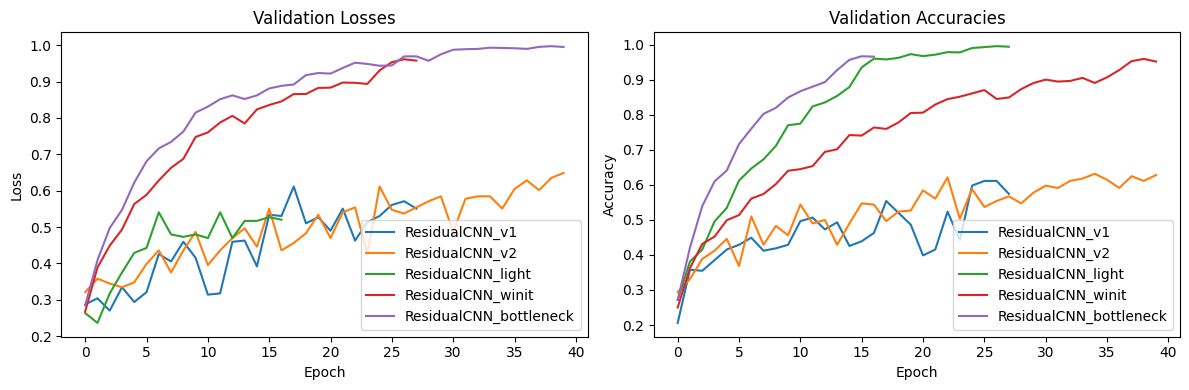

In [20]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Function to save the training history
def save_history(history, model_name):
    file_name = f"{model_name}_history.csv"
    df = pd.DataFrame(history)
    df.to_csv(file_name, index=False)
    print(f"History for {model_name} saved to {file_name}")

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience, patience_counter, best_val_loss, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        scheduler.step(val_loss)

    # Save the history
    history = {
        'epoch': list(range(1, epoch+2)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }
    save_history(history, model_name)

    return val_accuracies, train_accuracies

# Function to plot the training and validation losses/accuracies
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function for comparative plot of validation losses/accuracies across models
def comparative_plot(val_losses1, val_accuracies1, val_losses2, val_accuracies2, val_losses3, val_accuracies3, val_losses4, val_accuracies4, val_losses5, val_accuracies5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses1, label='ResidualCNN_v1')
    plt.plot(val_losses2, label='ResidualCNN_v2')
    plt.plot(val_losses3, label='ResidualCNN_light')
    plt.plot(val_losses4, label='ResidualCNN_winit')
    plt.plot(val_losses5, label='ResidualCNN_bottleneck')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Validation Losses")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies1, label='ResidualCNN_v1')
    plt.plot(val_accuracies2, label='ResidualCNN_v2')
    plt.plot(val_accuracies3, label='ResidualCNN_light')
    plt.plot(val_accuracies4, label='ResidualCNN_winit')
    plt.plot(val_accuracies5, label='ResidualCNN_bottleneck')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Validation Accuracies")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Define the transform with resizing and normalization
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets and data loaders
    train_dataset = GroceryStoreDataset(split='train', transform=transform)
    val_dataset = GroceryStoreDataset(split='val', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define models and parameters
    models = {
        'ResidualCNN_v1': ResidualCNN_v1(),
        'ResidualCNN_v2': ResidualCNN_v2(),
        'ResidualCNN_light': ResidualCNN_light(),
        'ResidualCNN_winit': ResidualCNN_winit(),
        'ResidualCNN_bottleneck': ResidualCNN_bottleneck()
    }

    table_data = []
    losses = []
    accuracies = []

    # Train each model and collect statistics
    for model_name, model in models.items():
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        num_epochs = 40
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        patience = 10
        best_val_loss = float('inf')
        patience_counter = 0

        val_accuracies, train_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs,
            scheduler, patience, patience_counter, best_val_loss, model_name
        )

        # Calculate statistics for table
        avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
        min_val_accuracy = min(val_accuracies)
        max_val_accuracy = max(val_accuracies)
        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        num_parameters = sum(p.numel() for p in model.parameters())

        table_data.append([
            model_name, '', num_parameters, avg_val_accuracy, min_val_accuracy,
            max_val_accuracy, avg_train_accuracy, len(val_accuracies)
        ])

        losses.append(val_accuracies)
        accuracies.append(train_accuracies)

    # Create and display the table
    df = pd.DataFrame(table_data, columns=[
        'model', 'label', 'parameters', 'avg_val_accuracy',
        'min_val_accuracy', 'max_val_accuracy', 'avg_train_accuracy', 'epochs'
    ])
    display(pd.DataFrame.from_dict(df))

    # Plot the comparative results for all models
    comparative_plot(*losses, *accuracies)
    
    return df

> ⚠️ **Please note: The plots shown are incorrect. Kindly disregard them.**

### COMMENTS ON RESULTS


* *ResidualCNN_v1*: Despite the high number of params, it shows a relatively lower average validation accuracy compared to some other models. The significant difference between training and validation accuracy suggests potential overfitting, where the model performs well on training data but struggles to generalize to validation data. The variability in validation accuracy is also quite high, reflecting instability in performance.

* *ResidualCNN_v2*: The validation accuracy range shows some variability, and while it is slightly better on average than ResidualCNN_v1, the model still exhibits a considerable gap between training and validation performance.

* *ResidualCNN_light*, with fewer parameters, shows the highest average validation accuracy among the models listed. This suggests that a lighter model can still achieve good performance, potentially due to better generalization or effective learning from the available data. The validation accuracy range is also relatively wide, indicating some variability, but the overall performance is promising.

* *ResidualCNN_winit* shows the highest average validation accuracy and training accuracy among all models. The consistent validation accuracy indicates better performance and stability. The high training accuracy suggests that the model can effectively learn from the training data.

* *ResidualCNN_bottleneck* has a moderate number of parameters and shows similar average validation accuracy to ResidualCNN_v1 but with a more modest range. The average training accuracy is comparable to other models, but the validation performance is somewhat lower, indicating potential issues with generalization. The smaller number of runs could also mean that the performance is less reliable or that more experimentation is needed to draw definitive conclusions.

The models with fewer parameters generally trade off some accuracy but gain efficiency, making them suitable for scenarios where computational cost is a concern.

### OVERALL COMMENTS



* We use a small **batch size** (32) because smaller batches tend to
introduce less noise into gradient estimates compared to larger batches. This helps stabilize training and can have a regularization effect, leading to better generalization. Although smaller batch sizes require more training time and computational resources due to more updates, they are often beneficial for more challenging tasks where overfitting is a concern. This approach encourages the model to learn more robust representations.

* **Dropout** significantly improves model accuracy and enhances generalization by preventing overfitting. By randomly "dropping out" a subset of neurons during training, dropout forces the model to learn redundant and distributed representations, making it more resistant to noise in the input data and better able to generalize to unseen examples.

* The first version of the model has a **large number of parameters**, making it overly complex and prone to **overfitting**. While this complexity enables the model to fit the training data well, it struggles to generalize to the validation set, as it memorizes specific patterns in the training data rather than learning broader, more transferable features. Reducing the model complexity by limiting parameters or adding regularization mechanisms can mitigate overfitting and improve generalization performance.



### Exploring undersampling for dataset balancing
While techniques such as data augmentation and rebalancing have not produced the expected improvements, another effective method to address class imbalance is undersampling. This approach involves reducing the number of instances from the majority classes to create a more balanced dataset. By focusing on the majority class and decreasing its size, we can alleviate the dominance of these classes and potentially improve the performance of our model. This technique can help in better training and evaluation by ensuring that the model does not become biased toward the more frequent classes. Indeed, we carefully select the amount of undersampling to avoid losing important information and to maintain the representativeness of the data.

In [28]:
from torch.utils.data import Subset
import numpy as np
from collections import Counter
import random

tsfms = T.Compose([
    T.Resize((INPUT_HEIGHT, INPUT_WIDTH)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize dataset
])

# Assuming your dataset object supports __getitem__ to retrieve (data, label)
train_dataset = GroceryStoreDataset(split="train", transform=tsfms)

# Step 1: Get all labels in the dataset
labels = [label for _, label in train_dataset]

# Step 2: Count occurrences of each class
class_counts = Counter(labels)

# Define the threshold to identify the largest classes (e.g., classes with more than 100 samples)
threshold = 100 # chosen after the visualization of data distribution

# Step 3: Create a list of indices for each class
class_indices = {class_label: [] for class_label in class_counts}
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

# Step 4: Undersample only the classes with a count above the threshold
undersampled_indices = []
for class_label, indices in class_indices.items():
    if class_counts[class_label] > threshold:
        # For classes with more samples than the threshold, reduce the sample size by half
        reduced_count = max(1, len(indices) // 3)
        undersampled_indices.extend(random.sample(indices, reduced_count))
    else:
        # For smaller classes, keep all their samples
        undersampled_indices.extend(indices)

# Step 5: Create a subset of the dataset using undersampled indices
undersampled_train_dataset = Subset(train_dataset, undersampled_indices)

# Step 6: Create a DataLoader using the undersampled dataset
train_loader = DataLoader(undersampled_train_dataset, batch_size=32, shuffle=True)

# Print class distribution before and after undersampling for verification
print("Original class distribution:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

reduced_class_counts = Counter([labels[idx] for idx in undersampled_indices])
print("\nReduced class distribution:")
for class_label, count in reduced_class_counts.items():
    print(f"Class {class_label}: {count} samples")

Original class distribution:
Class 0: 278 samples
Class 1: 41 samples
Class 2: 45 samples
Class 3: 46 samples
Class 4: 42 samples
Class 5: 31 samples
Class 6: 32 samples
Class 7: 154 samples
Class 8: 36 samples
Class 9: 57 samples
Class 10: 21 samples
Class 11: 28 samples
Class 12: 37 samples
Class 13: 116 samples
Class 14: 26 samples
Class 15: 22 samples
Class 16: 26 samples
Class 17: 34 samples
Class 18: 70 samples
Class 19: 247 samples
Class 20: 182 samples
Class 21: 33 samples
Class 22: 32 samples
Class 23: 48 samples
Class 24: 30 samples
Class 25: 51 samples
Class 26: 60 samples
Class 27: 181 samples
Class 28: 16 samples
Class 29: 22 samples
Class 30: 19 samples
Class 31: 43 samples
Class 32: 28 samples
Class 33: 25 samples
Class 34: 19 samples
Class 35: 23 samples
Class 36: 39 samples
Class 37: 38 samples
Class 38: 112 samples
Class 39: 75 samples
Class 40: 18 samples
Class 41: 127 samples
Class 42: 30 samples

Reduced class distribution:
Class 0: 92 samples
Class 1: 41 samples
C

Training Set Class Distribution:
Counter({0: 92, 19: 82, 39: 75, 18: 70, 20: 60, 26: 60, 27: 60, 9: 57, 7: 51, 25: 51, 23: 48, 3: 46, 2: 45, 31: 43, 4: 42, 41: 42, 1: 41, 36: 39, 13: 38, 37: 38, 12: 37, 38: 37, 8: 36, 17: 34, 21: 33, 6: 32, 22: 32, 5: 31, 24: 30, 42: 30, 11: 28, 32: 28, 14: 26, 16: 26, 33: 25, 35: 23, 15: 22, 29: 22, 10: 21, 30: 19, 34: 19, 40: 18, 28: 16})
 
Validation Set Class Distribution:
Counter({19: 29, 20: 26, 0: 22, 7: 20, 27: 20, 38: 15, 25: 10, 39: 10, 41: 8, 2: 6, 1: 5, 3: 5, 4: 5, 5: 5, 9: 5, 11: 5, 12: 5, 13: 5, 14: 5, 16: 5, 17: 5, 18: 5, 22: 5, 21: 5, 23: 5, 28: 5, 36: 5, 30: 5, 31: 5, 32: 5, 37: 5, 40: 5, 42: 5, 29: 4, 34: 4, 35: 4, 6: 3})
 


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


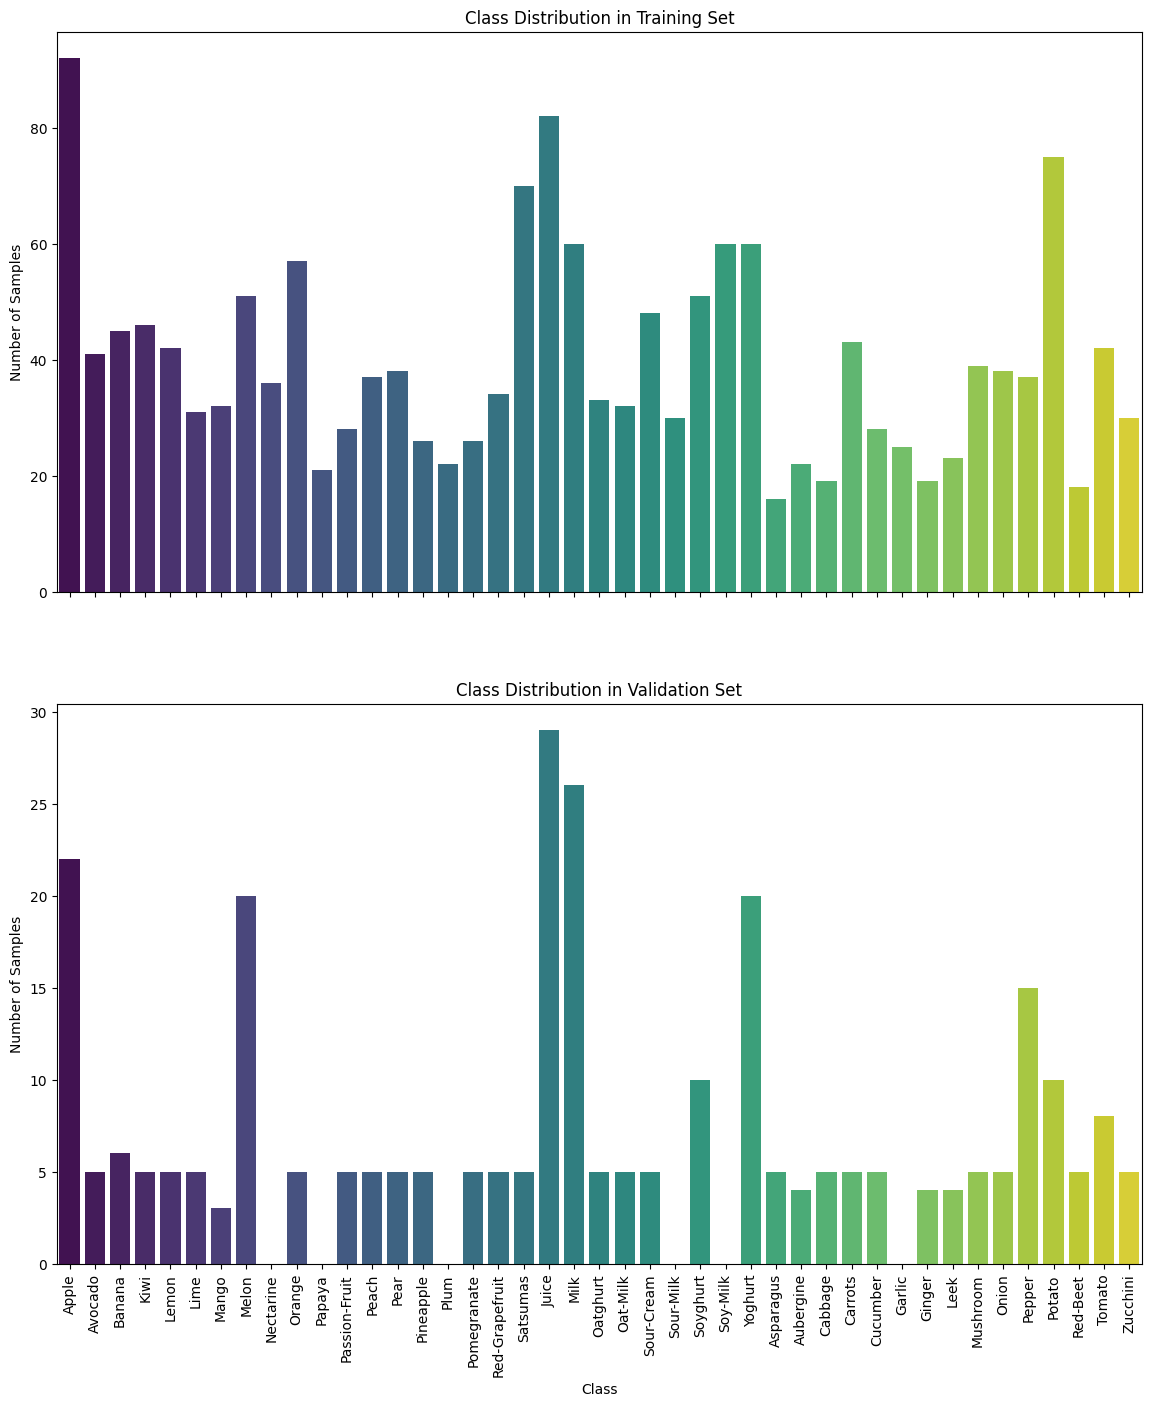

In [25]:
# Get the indices from the Subset
undersampled_indices = undersampled_train_dataset.indices

# Retrieve the labels from the original dataset using these indices
original_labels = [train_dataset[i][1] for i in undersampled_indices]

# Count the occurrences of each class label
train_label_counts = Counter(original_labels)
print("Training Set Class Distribution:")
print(train_label_counts)
print(" ")

# Count the occurrences of each class label in the validation set
val_label_counts = Counter(val_dataset.labels)
print("Validation Set Class Distribution:")
print(val_label_counts)
print(" ")

# Define the class names
class_names = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon",
    "Nectarine", "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear",
    "Pineapple", "Plum", "Pomegranate", "Red-Grapefruit", "Satsumas",
    "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", "Sour-Milk",
    "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage",
    "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom",
    "Onion", "Pepper", "Potato", "Red-Beet", "Tomato", "Zucchini"
]

# Convert label counts to lists sorted by class index
train_label_count_list = [train_label_counts[i] for i in range(len(class_names))]
val_label_count_list = [val_label_counts[i] for i in range(len(class_names))]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

# Plot training set distribution
sns.barplot(ax=axes[0], x=class_names, y=train_label_count_list, palette="viridis")
axes[0].set_title("Class Distribution in Training Set")
axes[0].set_ylabel("Number of Samples")

# Plot validation set distribution
sns.barplot(ax=axes[1], x=class_names, y=val_label_count_list, palette="viridis")
axes[1].set_title("Class Distribution in Validation Set")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Number of Samples")

plt.xticks(rotation=90)
plt.show()

#### Train again, avoiding to load the train dataset

In [30]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Function to save the training history
def save_history(history, model_name):
    file_name = f"{model_name}_history.csv"
    df = pd.DataFrame(history)
    df.to_csv(file_name, index=False)
    print(f"History for {model_name} saved to {file_name}")

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience, patience_counter, best_val_loss, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        scheduler.step(val_loss)

    # Save the history
    history = {
        'epoch': list(range(1, epoch+2)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }
    save_history(history, model_name)

    return val_accuracies, train_accuracies

# Function to plot the training and validation losses/accuracies
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function for comparative plot of validation losses/accuracies across models
def comparative_plot(val_losses1, val_accuracies1, val_losses2, val_accuracies2, val_losses3, val_accuracies3, val_losses4, val_accuracies4, val_losses5, val_accuracies5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses1, label='ResidualCNN_v1')
    plt.plot(val_losses2, label='ResidualCNN_v2')
    plt.plot(val_losses3, label='ResidualCNN_light')
    plt.plot(val_losses4, label='ResidualCNN_winit')
    plt.plot(val_losses5, label='ResidualCNN_bottleneck')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Validation Losses")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies1, label='ResidualCNN_v1')
    plt.plot(val_accuracies2, label='ResidualCNN_v2')
    plt.plot(val_accuracies3, label='ResidualCNN_light')
    plt.plot(val_accuracies4, label='ResidualCNN_winit')
    plt.plot(val_accuracies5, label='ResidualCNN_bottleneck')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Validation Accuracies")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Define the transform with resizing and normalization
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets and data loaders
    val_dataset = GroceryStoreDataset(split='val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define models and parameters
    models = {
        'ResidualCNN_v1': ResidualCNN_v1(),
        'ResidualCNN_v2': ResidualCNN_v2(),
        'ResidualCNN_light': ResidualCNN_light(),
        'ResidualCNN_winit': ResidualCNN_winit(),
        'ResidualCNN_bottleneck': ResidualCNN_bottleneck()
    }

    table_data = []
    losses = []
    accuracies = []

    # Train each model and collect statistics
    for model_name, model in models.items():
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        num_epochs = 40
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        patience = 10
        best_val_loss = float('inf')
        patience_counter = 0

        val_accuracies, train_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs,
            scheduler, patience, patience_counter, best_val_loss, model_name
        )

        # Calculate statistics for table
        avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
        min_val_accuracy = min(val_accuracies)
        max_val_accuracy = max(val_accuracies)
        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        num_parameters = sum(p.numel() for p in model.parameters())

        table_data.append([
            model_name, '', num_parameters, avg_val_accuracy, min_val_accuracy,
            max_val_accuracy, avg_train_accuracy, len(val_accuracies)
        ])

        losses.append(val_accuracies)
        accuracies.append(train_accuracies)

    # Create and display the table
    df = pd.DataFrame(table_data, columns=[
        'model', 'label', 'parameters', 'avg_val_accuracy',
        'min_val_accuracy', 'max_val_accuracy', 'avg_train_accuracy', 'epochs'
    ])
    display(pd.DataFrame.from_dict(df))

    # Plot the comparative results for all models
    #comparative_plot(*losses, *accuracies)
    
    return df, losses, accuracies

In [31]:
df, losses, accuracies = main()

Epoch [1/40], Train Loss: 2.9503, Train Acc: 0.1783, Val Loss: 3.0309, Val Acc: 0.1858
Epoch [2/40], Train Loss: 2.2878, Train Acc: 0.2856, Val Loss: 2.4987, Val Acc: 0.2162
Epoch [3/40], Train Loss: 2.1043, Train Acc: 0.3279, Val Loss: 2.9122, Val Acc: 0.1858
Epoch [4/40], Train Loss: 1.8781, Train Acc: 0.3930, Val Loss: 2.3153, Val Acc: 0.2331
Epoch [5/40], Train Loss: 1.5449, Train Acc: 0.4850, Val Loss: 3.2931, Val Acc: 0.2466
Epoch [6/40], Train Loss: 1.4745, Train Acc: 0.5413, Val Loss: 3.2342, Val Acc: 0.2568
Epoch [7/40], Train Loss: 1.2129, Train Acc: 0.6023, Val Loss: 2.6981, Val Acc: 0.2804
Epoch [8/40], Train Loss: 1.1575, Train Acc: 0.6317, Val Loss: 2.8038, Val Acc: 0.2466
Epoch [9/40], Train Loss: 1.0449, Train Acc: 0.6487, Val Loss: 2.4230, Val Acc: 0.4324
Epoch [10/40], Train Loss: 0.9224, Train Acc: 0.6974, Val Loss: 2.3462, Val Acc: 0.3986
Epoch [11/40], Train Loss: 0.6914, Train Acc: 0.7883, Val Loss: 2.9028, Val Acc: 0.2838
Epoch [12/40], Train Loss: 0.5717, Train 

,model,label,parameters,avg_val_accuracy,min_val_accuracy,max_val_accuracy,avg_train_accuracy,epochs
0,ResidualCNN_v1,,11203371,0.364515,0.185811,0.476351,0.753908,29
1,ResidualCNN_v2,,1242731,0.441134,0.229730,0.584459,0.752866,33
2,ResidualCNN_light,,315723,0.421537,0.172297,0.570946,0.686246,40
3,ResidualCNN_winit,,1242731,0.453503,0.195946,0.574324,0.816993,38
4,ResidualCNN_bottleneck,,534539,0.409705,0.250000,0.500000,0.736790,22


### COMMENTS ON RESULTS
* *ResidualCNN_winit* remains the top performer, despite a slight decrease in average validation accuracy, showing stability and high training accuracy.
* *ResidualCNN_v2* and *ResidualCNN_light* provide stable and competitive performance, with improved validation accuracy stability in the latter.
* *ResidualCNN_v1* and *ResidualCNN_bottleneck* show decreased validation performance, indicating potential issues with overfitting (v1) or underfitting (bottleneck) and suggesting further tuning might be needed.

### OVERALL COMMENTS
As we can see, if we reduce the number of samples, the process does not provide the expected results. Specifically, we noticed a worse performance when applying undersampling techniques. This decline in performance can be attributed to several factors:
* Smaller datasets naturally lead to higher variance in model training. With fewer samples, the model may become overly sensitive to noise or specific patterns present in the undersampled dataset, leading to less stable results. This is often observed as higher fluctuations in both training and validation loss, which means the model is less reliable and may produce inconsistent outputs.


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### Part 1

Approach: We approach the fine-tuning of the ResNet model by freezing the initial layers, which are primarily responsible for feature extraction, and focusing on adapting the final linear classifier to our specific task. This strategy leverages the pre-trained feature extraction capabilities of ResNet while customizing the final classification layer to fit our dataset.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience, save_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            if save_path:  
                torch.save(model.state_dict(), save_path)
                print(f'Model saved to {save_path}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                return train_losses, val_losses, train_accuracies, val_accuracies

    return train_losses, val_losses, train_accuracies, val_accuracies




def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def setup_model(num_classes):
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for param in model.fc.parameters():
        param.requires_grad = True

    return model

def setup_training_params(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    num_epochs = 40
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    patience = 10
    
    return criterion, optimizer, num_epochs, scheduler, patience

num_classes = 43  
model = setup_model(num_classes)

print("Model Summary:")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (3, 256, 256), device=device.type)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s] 


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14    

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Start model training with undersampling...
Epoch [1/40], Train Loss: 2.9747, Train Acc: 0.2610, Val Loss: 2.3396, Val Acc: 0.3953
Epoch [2/40], Train Loss: 1.6469, Train Acc: 0.6868, Val Loss: 1.7133, Val Acc: 0.6081
Epoch [3/40], Train Loss: 1.0772, Train Acc: 0.8399, Val Loss: 1.4827, Val Acc: 0.6385
Epoch [4/40], Train Loss: 0.7578, Train Acc: 0.9003, Val Loss: 1.2505, Val Acc: 0.6689
Epoch [5/40], Train Loss: 0.5989, Train Acc: 0.9296, Val Loss: 1.1780, Val Acc: 0.6588
Epoch [6/40], Train Loss: 0.4875, Train Acc: 0.9455, Val Loss: 1.1014, Val Acc: 0.7297
Epoch [7/40], Train Loss: 0.4132, Train Acc: 0.9560, Val Loss: 1.0011, Val Acc: 0.7230
Epoch [8/40], Train Loss: 0.3436, Train Acc: 0.9672, Val Loss: 0.9806, Val Acc: 0.6926
Epoch [9/40], Train Loss: 0.2912, Train Acc: 0.9812, Val Loss: 0.9884, Val Acc: 0.6993
Epoch [10/40], Train Loss: 0.2617, Train Acc: 0.9812, Val Loss: 0.9230, Val Acc: 0.7264
Epoch [11/40], Train Loss: 0.2295, Train Acc: 0.9859, Val Loss: 0.9499, Val Acc: 0.702

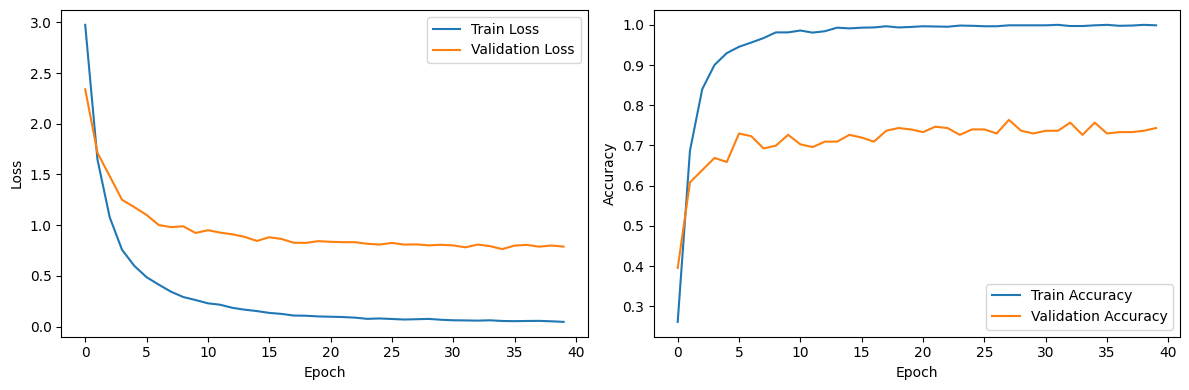

In [33]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
import random
from torchvision import transforms as T

def perform_undersampling(dataset, threshold=100):
    labels = [label for _, label in dataset]

    class_counts = Counter(labels)

    class_indices = {class_label: [] for class_label in class_counts}
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    undersampled_indices = []
    for class_label, indices in class_indices.items():
        if class_counts[class_label] > threshold:
            reduced_count = max(1, len(indices) // 3)
            undersampled_indices.extend(random.sample(indices, reduced_count))
        else:
            undersampled_indices.extend(indices)

    undersampled_dataset = Subset(dataset, undersampled_indices)

    return undersampled_dataset

def main_with_undersampling():
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = GroceryStoreDataset(split='train', transform=transform)
    val_dataset = GroceryStoreDataset(split='val', transform=transform)

    undersampled_train_dataset = perform_undersampling(train_dataset, threshold=100)
    train_loader = DataLoader(undersampled_train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    num_classes = train_dataset.get_num_classes()
    model = setup_model(num_classes)
    criterion, optimizer, num_epochs, scheduler, patience = setup_training_params(model)

    print("Start model training with undersampling...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience
    )
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

main_with_undersampling()

### Part 2

The adjustments made tweaking the hyperparameters, including lowering the learning rate, reducing the number of epochs, and refining the early stopping patience, are designed to enhance the model’s performance and stability. These changes ensure that the model converges more effectively while reducing the risk of overfitting. By implementing these fine-tuning strategies, we aim to achieve a model that not only performs well on training data but also generalizes effectively to unseen data.
In particular The learning rate was reduced because a lower learning rate is often beneficial during the final part of fine-tuning as it allows the model to make smaller, more precise updates to the weights. This is particularly useful when the model is already close to a good solution, as it helps to avoid overshooting and ensures that the learning process becomes more stable and focused on fine-grained adjustments.

Loading pre-trained model from /kaggle/input/best/transformers/default/1/best_model.pth


/tmp/ipykernel_36/734809221.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Pre-trained model loaded successfully.
Start model training
Epoch [1/30], Train Loss: 0.0230, Train Acc: 0.9953, Val Loss: 0.8366, Val Acc: 0.7872
Epoch [2/30], Train Loss: 0.0374, Train Acc: 0.9900, Val Loss: 0.7025, Val Acc: 0.7669
Epoch [3/30], Train Loss: 0.0268, Train Acc: 0.9935, Val Loss: 0.5455, Val Acc: 0.8209
Epoch [4/30], Train Loss: 0.0173, Train Acc: 0.9947, Val Loss: 0.7521, Val Acc: 0.7770
Epoch [5/30], Train Loss: 0.0091, Train Acc: 0.9971, Val Loss: 0.7190, Val Acc: 0.7973
Epoch [6/30], Train Loss: 0.0023, Train Acc: 1.0000, Val Loss: 0.7169, Val Acc: 0.7703
Epoch [7/30], Train Loss: 0.0018, Train Acc: 0.9994, Val Loss: 0.6912, Val Acc: 0.7939
Epoch [8/30], Train Loss: 0.0020, Train Acc: 0.9994, Val Loss: 0.7365, Val Acc: 0.7804
Epoch [9/30], Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.6693, Val Acc: 0.7736
Epoch [10/30], Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.6639, Val Acc: 0.7872
Epoch [11/30], Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.662

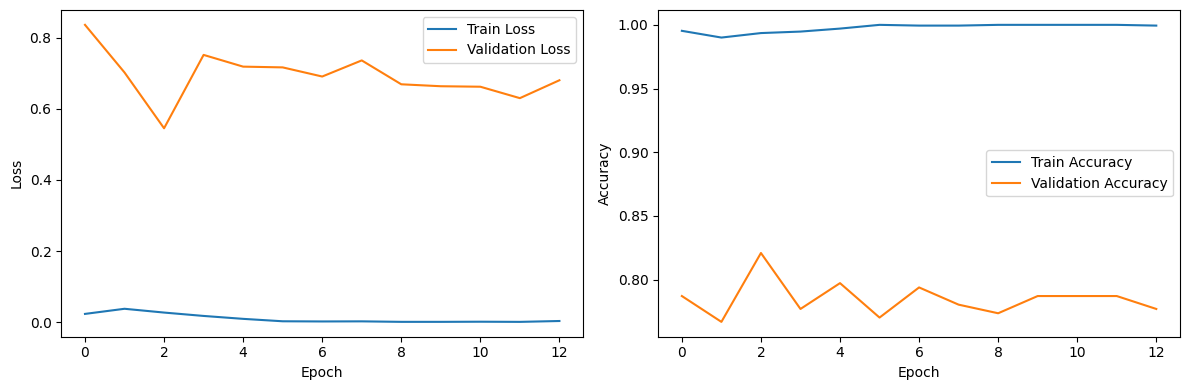

In [35]:
def setup_model(num_classes):
    model = models.resnet18(pretrained=False) 

    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

def setup_training_params(model):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    num_epochs = 30 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    patience = 10  
    
    return criterion, optimizer, num_epochs, scheduler, patience

def main_with_augmentation(model_path=None):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = GroceryStoreDataset(split='train', transform=transform)
    val_dataset = GroceryStoreDataset(split='val', transform=transform)

    undersampled_train_dataset = perform_undersampling(train_dataset, threshold=100)
    train_loader = DataLoader(undersampled_train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    num_classes = train_dataset.get_num_classes()
    model = setup_model(num_classes)

    if model_path:
        print(f"Loading pre-trained model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        print("Pre-trained model loaded successfully.")

    criterion, optimizer, num_epochs, scheduler, patience = setup_training_params(model)

    print("Start model training")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience
    )
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)
    
model_path = 'best_model.pth' 
main_with_augmentation(model_path)